In [1]:
import torch
from torch import nn
import d2l

#### 1. 生成数据集

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05

In [3]:
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)

In [4]:
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

#### 2. 初始化模型参数

In [5]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

#### 3. 定义L2范数惩罚项

In [6]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

#### 4. 训练模型

In [7]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='迭代周期', ylabel='损失', yscale='log',
                            xlim=[5, num_epochs], legend=['训练数据集', '测试数据集'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

#### 不使用惩罚项

w的L2范数是： 12.856600761413574


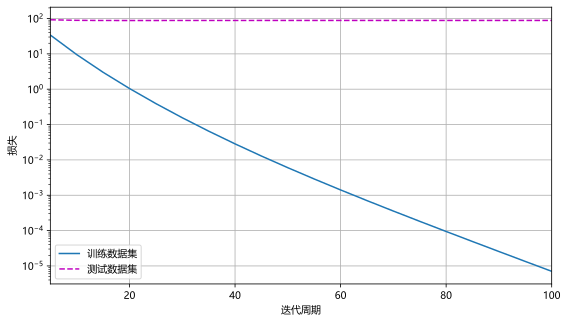

In [8]:
train(lambd=0)

#### 使用权重衰减

w的L2范数是： 0.04319779574871063


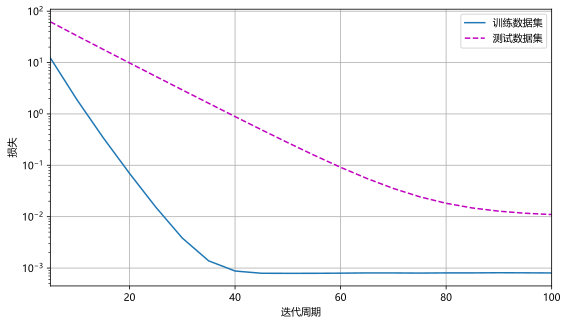

In [14]:
train(lambd=5)

#### 5. 权重衰减（简洁实现）

In [15]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    trainer = torch.optim.SGD([{"params": net[0].weight, 'weight_decay': wd}, {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='迭代周期', ylabel='损失', yscale='log', xlim=[5, num_epochs], legend=['训练数据集', '测试数据集'])
    for i in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (i + 1) % 5 == 0:
            animator.add(i + 1, (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)))  
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 14.68860149383545


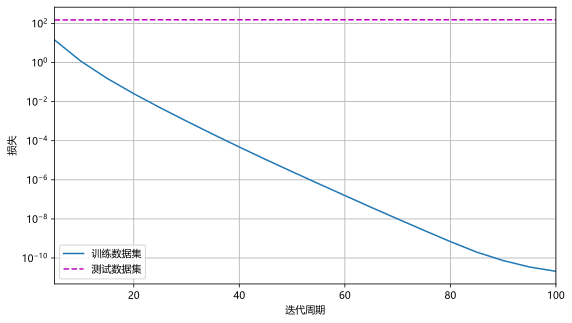

In [16]:
# 权重w不衰减
train_concise(0)

w的L2范数： 0.12315840274095535


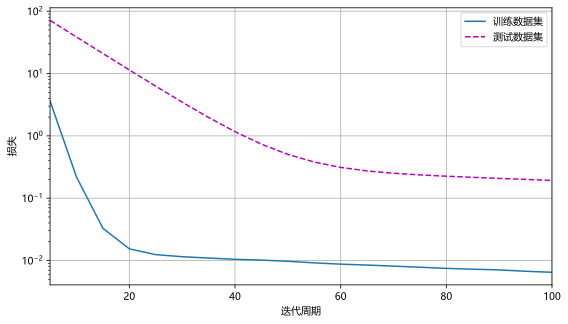

In [17]:
# 权重衰减
train_concise(5)